In [14]:
%matplotlib widget
import os
import pydicom as dicom
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
from rt_utils import RTStructBuilder
# Error handling
from pydicom.errors import InvalidDicomError 
from PIL import Image
from PIL import ImageDraw
from pathlib import Path
import cv2 as cv

In [15]:
PATIENT_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF"
MRI_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF/MRI_028_PRO_pCT_CGFL"
CT_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF/CT_028_PRO_pCT_CGFL"
CTre_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF/CTre_028_PRO_pCT_CGFL"
RTSTRUCT_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF/STRUC_028_PRO_pCT_CGFL"
MASK_PATH = "/Users/manoskoutoulakis/Documents/ms_thesis/sample_CGLF/MASKS"

In [16]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


##########################################################################
# Multi-slice view code extracted and adapted from: 

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(mask_volume, mri_volume,title_mask_volume, title_mri_volume, no_axis=False):
    remove_keymap_conflicts({'j', 'k'})
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.volume = mask_volume
    ax1.index = len(mask_volume) // 2
    print(len(mask_volume) // 2)
    ax1.imshow(mask_volume[ax1.index],cmap="gray")
    ax1.set_title(title_mask_volume)
#     if eq_volume /not None:
    ax2.volume = mri_volume
    ax2.index = len(mri_volume) // 2
    print(len(mri_volume) // 2)
    
    ax2.imshow(mri_volume[ax2.index],cmap="gray", interpolation="bicubic")
    ax2.set_title(title_mri_volume)
    fig.canvas.mpl_connect('key_press_event', process_key)
    
            
def process_key(event):
    # Process key_press events
    fig = event.canvas.figure
    ax1 = fig.axes[0]
    ax2 = fig.axes[1]

    if event.key == 'j':
        previous_slice(ax1)
        previous_slice(ax2)
    elif event.key == 'k':
        next_slice(ax1) 
        next_slice(ax2) 
    fig.canvas.draw()

def previous_slice(ax):
    # Go to the previous slice
    volume = ax.volume
    ax.index = (ax.index-1) % len(volume)
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    # Go to the next slice
    volume = ax.volume
    ax.index = (ax.index+1) % len(volume)
    ax.images[0].set_array(volume[ax.index])

In [17]:
"""
The code block below is just for testing to get all the available
segments from the RT Structure file
"""

ds = dicom.read_file(RTSTRUCT_PATH + "/RS070001.dcm",force=True)
# Available structures
# ds.dir("ROIContourSequence")
roi_segments = ds.StructureSetROISequence # ds[0x3006, 0x20].value # Returns the sequence of the segments
list_of_segments = [
    segment.ROIName #segment[0x3006,0x26].value # It get the name of the segment
    for segment in roi_segments 
    if segment.ROIGenerationAlgorithm == "MANUAL" # segment[0x3006, 0x36].value == "MANUAL" # Checks if the segmentation took place manually 
]
# list_of_segments
# [i for i in ds.StructureSetROISequence]

In [18]:
segments= [
    'PAROI_RECTUM',
    'PAROI_VESSIE',
    'OARS_TETE_FEMORA',
    'PROSTATE_38_PRV_',
]

if not os.path.exists(MASK_PATH):
    os.mkdir(MASK_PATH)
else:
    print("File exists.")
    
# Load existing RT Struct. Requires the series path and existing RT Struct path
rtstruct = RTStructBuilder.create_from(
  dicom_series_path= MRI_PATH, 
  rt_struct_path= RTSTRUCT_PATH+"/RS070001.dcm"
)
"""
The rois that I want to segment (Experimental)
1. Prostate --- PROSTATE_38_PRV_
2. Bladder --- PAROI_VESSIE
3. Rectum ---Paroi_rectum 
4. Femoral (Both Sides) --- OARS_TETE_FEMORA
5. Femoral Righ --- TETE_FEMORALE_D
6. Femoral Left --- TETE_FEMORALE_G
"""
masks = {}
for segment in segments:
    masks[segment] = rtstruct.get_roi_mask_by_name(segment)
#     masks[segment] = np.array([np.transpose(sl) for sl in rtstruct.get_roi_mask_by_name(segment)])
    print("Masks for segment: {segment} exported to {type_exported}".format(segment=segment, type_exported=type(masks[segment])))

File exists.
Masks for segment: PAROI_RECTUM exported to <class 'numpy.ndarray'>
Masks for segment: PAROI_VESSIE exported to <class 'numpy.ndarray'>
Masks for segment: OARS_TETE_FEMORA exported to <class 'numpy.ndarray'>
Masks for segment: PROSTATE_38_PRV_ exported to <class 'numpy.ndarray'>


In [19]:
rt_struct = dicom.read_file(RTSTRUCT_PATH + "/RS070001.dcm",force=True)
# Available structures
# ds.dir("ROIContourSequence")
roi_segments = rt_struct.StructureSetROISequence # ds[0x3006, 0x20].value # Returns the sequence of the segments
list_of_segments = [
    segment #segment[0x3006,0x26].value # It get the name of the segment
    for segment in roi_segments 
    if segment.ROIGenerationAlgorithm == "MANUAL" # segment[0x3006, 0x36].value == "MANUAL" # Checks if the segmentation took place manually 
]
list_of_segments

[(3006, 0022) ROI Number                          IS: "1"
 (3006, 0024) Referenced Frame of Reference UID   UI: 2.16.840.1.114493.1.4.240.3.20201019133857243
 (3006, 0026) ROI Name                            LO: 'Peau'
 (3006, 0028) ROI Description                     ST: 'Peau'
 (3006, 0036) ROI Generation Algorithm            CS: 'MANUAL',
 (3006, 0022) ROI Number                          IS: "2"
 (3006, 0024) Referenced Frame of Reference UID   UI: 2.16.840.1.114493.1.4.240.3.20201019133857243
 (3006, 0026) ROI Name                            LO: 'CTV_BOOST'
 (3006, 0028) ROI Description                     ST: 'CTV_Boost'
 (3006, 0036) ROI Generation Algorithm            CS: 'MANUAL',
 (3006, 0022) ROI Number                          IS: "3"
 (3006, 0024) Referenced Frame of Reference UID   UI: 2.16.840.1.114493.1.4.240.3.20201019133857243
 (3006, 0026) ROI Name                            LO: 'PTV_PROSTATE_38'
 (3006, 0028) ROI Description                     ST: 'PTV_Prostate_38'


Functions

In [20]:
def parse_dicom_file(filename):
    """
    Parse the given DICOM filename
    :param filename: file path to the DICOM file to parse
    :return: diction with dicom image data
    """
    
    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array
        
        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0
        
        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        return dcm_image
    except InvalidDicomError:
        return None

    
def get_roi_contour_ds(rt_sequence, index):
    """Extract the desired ROI contour datasets
    from RT sequence
    : param rt_sequence: dicom.dataset.FileDataset): Contour file dataset, what you get after reading contour DICOM file
    : param index: int: Index for ROI Sequence
    : return: list: list of ROI contour dicom.dataset.Datasets
    """
    ROI= rt_sequence.ROIContourSequence[index]
    print(ROI)
    # Contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours

def contour2poly(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    print(contour_dataset.ContourImageSequence)
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = dicom.read_file(path + img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [(np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))  for x, y, _ in coord]
    return pixel_coords, img_ID, img_shape


def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

def get_mask_dict(contour_datasets, path):
    """
    Inputs:
        contour_datasets (list): list of dicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)
#     print(img_contours_dict)
    for cdataset in contour_datasets:
#         print(c/dataset)
        coords, img_id, shape = contour2poly(cdataset, path)
        mask = poly_to_mask(coords, *shape)
        img_contours_dict[img_id] += mask
    
    return img_contours_dict

def get_roi_names(contour_data):
#     print(contour_data)
    roi_seq_names = [roi_seq.ROIName for roi_seq in list(contour_data.StructureSetROISequence)]
    return roi_seq_names

In [37]:
scans = [scan for scan in load_scan(MRI_PATH)]
rt_struct = dicom.read_file(RTSTRUCT_PATH + "/RS070001.dcm",force=True)

In [6]:
rt_struct.StructureSetROISequence[18]


(3006, 0022) ROI Number                          IS: "19"
(3006, 0024) Referenced Frame of Reference UID   UI: 2.16.840.1.114493.1.4.240.3.20201019133857243
(3006, 0026) ROI Name                            LO: 'OARS_TETE_FEMORA'
(3006, 0028) ROI Description                     ST: 'OArs_tete femorale'
(3006, 0036) ROI Generation Algorithm            CS: 'MANUAL'

In [7]:
rt_struct.ROIContourSequence[18].ContourSequence[1]

(3006, 0016)  Contour Image Sequence  1 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storage
   (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114493.1.4.240.3.20201019133859640
   ---------
(3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
(3006, 0046) Number of Contour Points            IS: "126"
(3006, 0050) Contour Data                        DS: Array of 378 elements

In [9]:
# Load the scans in given folder path
def load_scan(path, rt_path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    rt_struct = dicom.read_file(RTSTRUCT_PATH+'/RS070001.dcm',force=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices,rt_struct
#     [scan for scan in scans if scan.SOPInstanceUID == cvt_s_ref_slice]

def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

def get_contours(referenced_slice,rt_struct, index):
    return np.array([
        i.ContourData 
        for i in rt_struct.ROIContourSequence[index].ContourSequence 
        if i.ContourImageSequence[0].ReferencedSOPInstanceUID == cvt_s_ref_slice
        # The ContourImageSequence contains multiple sequences for different slices 
        # Check how to perform the iteration through the sequencess
    ][0]).reshape((-1,3))

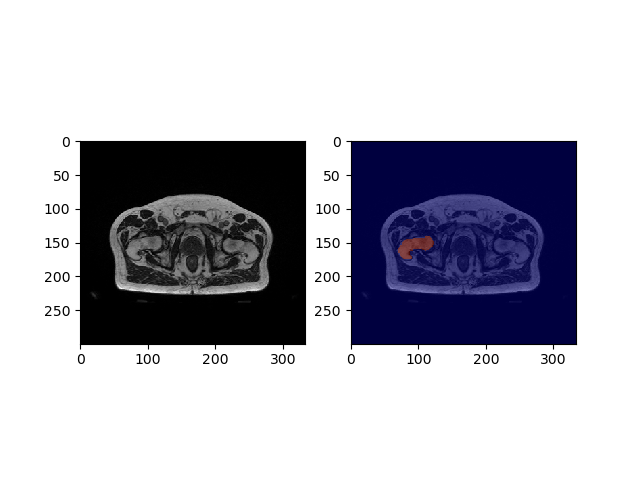

In [10]:


cvt_s_ref_slice="2.16.840.1.114493.1.4.240.3.20201019133859963"

contours = np.array([
    i.ContourData 
    for i in rt_struct.ROIContourSequence[18].ContourSequence 
    if i.ContourImageSequence[0].ReferencedSOPInstanceUID == cvt_s_ref_slice
][0]).reshape((-1,3))

cvt_s_slice = [scan for scan in scans if scan.SOPInstanceUID == cvt_s_ref_slice][0]


img_shape = cvt_s_slice.pixel_array.shape
mask = np.zeros(img_shape).astype(bool)

# physical distance between the center of each pixel
x_spacing, y_spacing = float(cvt_s_slice.PixelSpacing[0]), float(cvt_s_slice.PixelSpacing[1])

# this is the center of the upper left voxel
origin_x, origin_y, _ = cvt_s_slice.ImagePositionPatient

# y, x is how it's mapped
pixel_coords = [
    (np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))
    for x, y, _ in contours
]



masked = poly_to_mask(pixel_coords, img_shape[1],img_shape[0])
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cvt_s_slice.pixel_array, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(cvt_s_slice.pixel_array, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)
plt.show()

In [211]:
pixel_coords = np.array(
    [
        np.array([
            np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing)
                 ])
        for x, y, _ in contours
    ]
)
pixel_coords[:,0]


array([156., 157., 158., 159., 160., 160., 161., 161., 161., 162., 162.,
       163., 163., 163., 163., 163., 162., 162., 163., 163., 163., 162.,
       161., 161., 160., 160., 160., 159., 158., 157., 157., 156., 155.,
       155., 155., 154., 154., 154., 154., 154., 153., 153., 153., 154.,
       154., 155., 155., 155.])

In [45]:
rt_struct.ROIContourSequence[18]

(3006, 002a) ROI Display Color                   IS: [255, 0, 0]
(3006, 0040)  Contour Sequence  87 item(s) ---- 
   (3006, 0016)  Contour Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: MR Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114493.1.4.240.3.20201019133859593
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: "116"
   (3006, 0050) Contour Data                        DS: Array of 348 elements
   ---------
   (3006, 0016)  Contour Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: MR Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114493.1.4.240.3.20201019133859640
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: "126"
   (3006, 0050) Con